In [1]:
from pathlib import Path
import sys
sys.path.insert(0,'sim/lib')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from distributions import CovidDistributions as d
from scipy.stats import lognorm
from scipy.stats import gamma


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
distr = d("GER")

In [4]:
T = 100
times = range(T)
#times = list(np.linspace(0,T+1,num=(T+1)*24,endpoint= False))
num_age_groups = len(distr.p_hospital_by_age)
asym_frac_ages = distr.alpha*np.ones(num_age_groups) ##fraction of asymptomatic nodes
hosp_frac_ages = distr.p_hospital_by_age
dead_frac_ages = distr.fatality_rates_by_age


In [10]:
### E-> I transition
# expo-> iasy
mu_expo_to_iasy = distr.incubation_mean_of_lognormal-distr.median_infectious_without_symptom
std_expo_to_iasy = distr.incubation_std_of_lognormal
mulog_expo_to_iasy, stdlog_expo_to_iasy = d.normal_to_lognormal(d,mu = mu_expo_to_iasy,std = std_expo_to_iasy)
p_expo_to_iasy = lognorm.pdf(times, stdlog_expo_to_iasy,scale = np.exp(mulog_expo_to_iasy))

# expo -> ipre

mu_expo_to_ipre = distr.incubation_mean_of_lognormal-distr.median_infectious_without_symptom
std_expo_to_ipre = distr.incubation_std_of_lognormal
mulog_expo_to_ipre, stdlog_expo_to_ipre = d.normal_to_lognormal(d,mu = mu_expo_to_ipre,std = std_expo_to_ipre)
p_expo_to_ipre = lognorm.pdf(times, stdlog_expo_to_ipre,scale = np.exp(mulog_expo_to_ipre))

# trace over
tau_E_to_I = np.mean(np.outer(asym_frac_ages,p_expo_to_iasy) + np.outer(1.0 - asym_frac_ages,p_expo_to_ipre), axis = 0)

In [13]:
### I -> R transition

# iasy -> resi
mu_iasy_to_resi = distr.median_asymp_to_resi
std_iasy_to_resi = 1.0
mulog_iasy_to_resi, stdlog_iasy_to_resi = d.normal_to_lognormal(d,mu = mu_iasy_to_resi,std = std_iasy_to_resi)
p_iasy_to_resi = lognorm.pdf(times, stdlog_iasy_to_resi,scale = np.exp(mulog_iasy_to_resi))

##### Ipre -> Isym -> resi #####################

# ipre-> isym
mu_ipre_to_isym = distr.median_infectious_without_symptom
std_ipre_to_isym = 1.0
mulog_ipre_to_isym, stdlog_ipre_to_isym = d.normal_to_lognormal(d,mu = mu_ipre_to_isym,std = std_ipre_to_isym)
p_ipre_to_isym = lognorm.pdf(times, stdlog_ipre_to_isym,scale = np.exp(mulog_ipre_to_isym))

# isym -> resi
mu_isym_to_resi = distr.median_symp_to_resi
std_isym_to_resi = 1.0
mulog_isym_to_resi, stdlog_isym_to_resi = d.normal_to_lognormal(d,mu = mu_isym_to_resi,std = std_isym_to_resi)
p_isym_to_resi = lognorm.pdf(times,stdlog_isym_to_resi,scale = np.exp(mulog_isym_to_resi))

p_ipre_isym_resi = np.convolve(p_ipre_to_isym,p_isym_to_resi)[:T]

##### Ipre -> Isym -> Dead #####################

# isym -> dead
mu_isym_to_dead = distr.symp_to_death_mean_of_lognormal
std_isym_to_dead = 1.0
mulog_isym_to_dead, stdlog_isym_to_dead = d.normal_to_lognormal(d,mu = mu_isym_to_dead,std = std_isym_to_dead)
p_isym_to_dead = lognorm.pdf(times,stdlog_isym_to_dead,scale = np.exp(mulog_isym_to_dead))

p_ipre_isym_dead = np.convolve(p_ipre_to_isym,p_isym_to_dead)[:T]

tau_I_to_R = np.mean(np.outer(asym_frac_ages,p_iasy_to_resi) \
    + np.outer((1-asym_frac_ages)*(1-dead_frac_ages),p_ipre_isym_resi) \
    + np.outer((1-asym_frac_ages)*(dead_frac_ages),p_ipre_isym_dead),axis = 0)



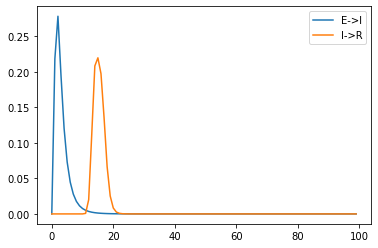

In [14]:
##plot

plt.plot(tau_E_to_I, label = "E->I")
plt.plot(tau_I_to_R, label = "I->R")
plt.legend()

In [16]:
# save data for fit (in julia)
np.savetxt("tau_E_to_I.txt",tau_E_to_I)
np.savetxt("tau_I_to_R.txt",tau_I_to_R)